# R F M

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pyodbc 

# Connecting SQL to Jupyter Notebook

In [4]:
Cnt2SQL = pyodbc.connect(
"Driver={SQL Server Native Client 11.0};"
    #REPLACE TCOKER with your own Server Name(you can find the server name on the connect window when you open sql mgt studio)
 "Server=DESKTOP-NEDV4G5;"
    # REPLACE AdventureWorksDW2012 with the database you want
"Database=AdventureWorks2012;"
"Trusted_Connection=yes;")

In [9]:
df = pd.read_sql_query("""
SELECT A.[OrderDate],
A.[SalesOrderID],
D.FirstName+' '+D.LastName AS 'Customer',
B.[LineTotal] as Revenue
FROM [Sales].[SalesOrderHeader] AS A
LEFT JOIN [Sales].[SalesOrderDetail] AS B
ON A.SalesOrderID = B.SalesOrderID
LEFT JOIN [Sales].[Customer] AS C
ON A.CustomerID = C.CustomerID
LEFT JOIN [Person].[Person] AS D
ON C.PersonID = D.BusinessEntityID""",Cnt2SQL)

In [10]:
df.head()

,OrderDate,SalesOrderID,Customer,Revenue
0,2011-05-31,43659,James Hendergart,2024.994
1,2011-05-31,43659,James Hendergart,6074.982
2,2011-05-31,43659,James Hendergart,2024.994
3,2011-05-31,43659,James Hendergart,2039.994
4,2011-05-31,43659,James Hendergart,2039.994


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 4 columns):
OrderDate       121317 non-null datetime64[ns]
SalesOrderID    121317 non-null int64
Customer        121317 non-null object
Revenue         121317 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.7+ MB


In [12]:
df.isnull().sum()

OrderDate       0
SalesOrderID    0
Customer        0
Revenue         0
dtype: int64

In [13]:
df.columns

Index(['OrderDate', 'SalesOrderID', 'Customer', 'Revenue'], dtype='object')

In [14]:
df.describe()

,SalesOrderID,Revenue
count,121317.000000,121317.000000
mean,57827.363782,905.449207
std,9009.147902,1693.417389
min,43659.000000,1.374000
25%,49884.000000,24.990000
50%,57029.000000,134.982000
75%,65490.000000,1120.490000
max,75123.000000,27893.619000


### Top 10 frequently comming customer names

In [16]:
df.Customer.value_counts().head(10)

Reuben D'sa           530
Richard Lum           482
Ryan Calafato         451
Yale Li               446
Marcia Sultan         441
Holly Dickson         440
Robert Vessa          436
Della Demott Jr       436
Sandra Maynard        432
Joseph Castellucio    429
Name: Customer, dtype: int64

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

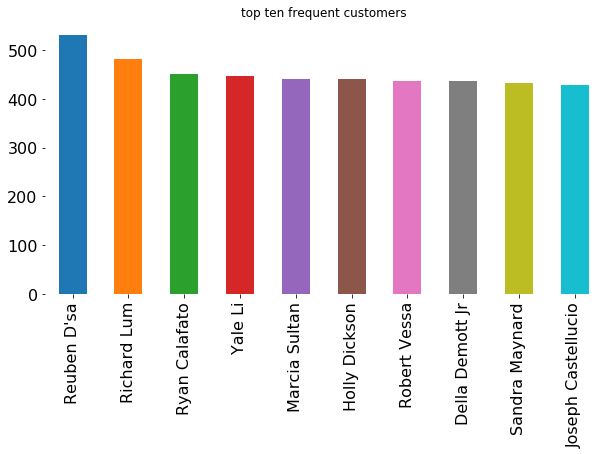

In [19]:
df['Customer'].value_counts().head(10).plot.bar(figsize=(10,5), fontsize=16, title='top ten frequent customers')
sns.despine(bottom=True, left=True)                                         

In [21]:
Dates = pd.to_datetime(df['OrderDate'])

- Top Ten Dates In Which Orders Are Placed

In [23]:
Dates.value_counts().head(10)

2013-06-30    3876
2013-07-31    3852
2013-10-30    3202
2014-05-01    3126
2014-03-31    3065
2013-09-30    3030
2012-06-30    2973
2012-09-30    2351
2014-01-29    2347
2013-03-30    2319
Name: OrderDate, dtype: int64

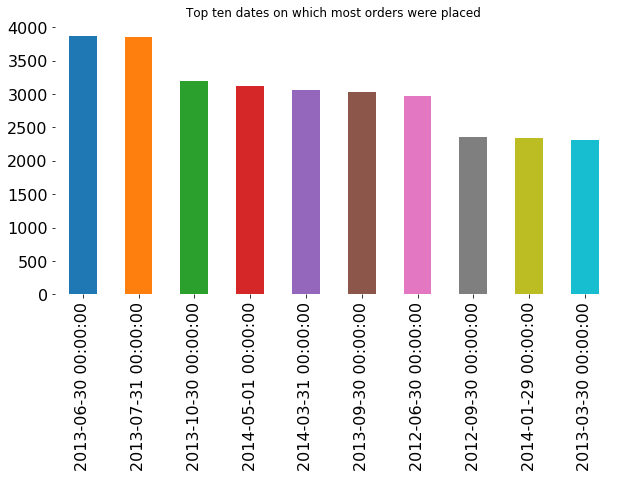

In [24]:
df['OrderDate'].value_counts().head(10).plot.bar(figsize=(10,5), fontsize=16, title='Top ten dates on which most orders were placed')
sns.despine(bottom=True, left=True)

In [25]:
# Finding out the most recent / last date in the OrderDate column
df['OrderDate'].max()

Timestamp('2014-06-30 00:00:00')

## Creating the RFM Table

 Since recencyis claculated for a point in time and the dataset last order date is June 2014, that's the date that'll be used to calculate RECENCY

Set this date to current day & extract all orders until yesterday

In [27]:
import datetime as dt
Now = dt.datetime(2014,6,30)
Now

datetime.datetime(2014, 6, 30, 0, 0)

In [28]:
df['OrderDate'] = Dates

In [29]:
RFMtable = df.groupby('Customer').agg({'OrderDate': lambda x: (Now - x.max()).days, #RECENCY
                                      'SalesOrderID': lambda x: len(x), #FREQUENCY
                                      'Revenue': lambda x: x.sum()}) #MONETARY VALUE

RFMtable['OrderDate'] = RFMtable['OrderDate'].astype(int)
RFMtable.rename(columns={'OrderDate': 'Recency',
                         'SalesOrderID': 'Frequency',
                         'Revenue': 'Monetary Value'}, inplace =True)

## Validating RFM table

In [30]:
RFMtable.head()

,Recency,Frequency,Monetary Value
Customer,,,
A. Leonetti,60,4,2930.5488
Aaron Adams,275,4,117.9600
Aaron Alexander,46,1,69.9900
Aaron Allen,788,1,3399.9900
Aaron Baker,141,2,1750.9800


In [34]:
RFMtable = RFMtable.round(0)

In [35]:
RFMtable.head()

,Recency,Frequency,Monetary Value
Customer,,,
A. Leonetti,60,4,2931.0
Aaron Adams,275,4,118.0
Aaron Alexander,46,1,70.0
Aaron Allen,788,1,3400.0
Aaron Baker,141,2,1751.0


<b>Conclusion:</b> Customer  <b>Aaron Adams</b> has 

| Recency | Frequency | Monetary Value |
|:-------:|:---------:|:--------:|
| 275 days | 4 | $118 |

<b>Recency(R):</b>  Time since last purchase<br/>
<b>Frequency(F):</b>  Total number of purchase<br/>
<b>Monetary Value(M):</b> Total monetary value

In [39]:
aaron_adams = df[df['Customer'] == 'Aaron Adams']
aaron_adams

,OrderDate,SalesOrderID,Customer,Revenue
60133,2013-09-28,56918,Aaron Adams,3.99
60134,2013-09-28,56918,Aaron Adams,24.99
60135,2013-09-28,56918,Aaron Adams,34.99
60136,2013-09-28,56918,Aaron Adams,53.99


Inserting the date of Aaron purchase and comparing it to the <b>recency</b> in the <b>rfmTable</b> we verify our RFM table is correct.

In [40]:
(Now - dt.datetime(2013,9,28)).days == 275

True

In [41]:
RFMtable['Frequency'].max()

530

In [42]:
#Customer who made maximum purchases
RFMtable[RFMtable['Frequency'] == 530]

,Recency,Frequency,Monetary Value
Customer,,,
Reuben D'sa,60,530,841909.0


In [48]:
df = df.round()

In [57]:
Reuben = df[df['Customer'] == "Reuben D'sa"]
Reuben.head()

,OrderDate,SalesOrderID,Customer,Revenue
1541,2011-08-01,44086,Reuben D'sa,6120.0
1542,2011-08-01,44086,Reuben D'sa,819.0
1543,2011-08-01,44086,Reuben D'sa,57.0
1544,2011-08-01,44086,Reuben D'sa,8160.0
1545,2011-08-01,44086,Reuben D'sa,8100.0


In [51]:
#Customer who has maximum monetary value
RFMtable['Monetary Value'].max()

877303.0

In [ ]:
#Customer who has maximum monetary value
RFMtable.Monetary Value.ax()

In [54]:
RFMtable[RFMtable['Monetary Value'] == 877303]

,Recency,Frequency,Monetary Value
Customer,,,
Roger Harui,91,301,877303.0


In [56]:
Roger = df[df['Customer'] == 'Roger Harui']
Roger.head()

,OrderDate,SalesOrderID,Customer,Revenue
534,2011-07-01,43849,Roger Harui,4050.0
535,2011-07-01,43849,Roger Harui,29.0
536,2011-07-01,43849,Roger Harui,4050.0
537,2011-07-01,43849,Roger Harui,4080.0
538,2011-07-01,43849,Roger Harui,20.0


## Determining RFM Quartiles 

In [60]:
quartiles = RFMtable.quantile(q=[0.25,0.5,0.75])
quartiles

,Recency,Frequency,Monetary Value
0.25,85.0,2.0,55.0
0.50,165.0,3.0,554.0
0.75,263.0,4.0,2849.0


## Creating the RFM segmenttion table

In [61]:
rfmSegmentation = RFMtable

We create two classes for the RFM segmentation since, being <b>high recency is bad</b>, while <b>high frequency and monetary value is good.</b>

In [62]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [64]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['Recency'].apply(RClass, args=('Recency',quartiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['Frequency'].apply(FMClass, args=('Frequency',quartiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['Monetary Value'].apply(FMClass, args=('Monetary Value',quartiles,))

In [65]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [66]:
rfmSegmentation.head()

,Recency,Frequency,Monetary Value,R_Quartile,F_Quartile,M_Quartile,RFMClass
Customer,,,,,,,
A. Leonetti,60,4,2931.0,1,2,1,121
Aaron Adams,275,4,118.0,4,2,3,423
Aaron Alexander,46,1,70.0,1,4,3,143
Aaron Allen,788,1,3400.0,4,4,1,441
Aaron Baker,141,2,1751.0,2,4,2,242


In [67]:
rfmSegmentation.to_csv('rfm_table.csv', sep=',')

Who are the top 5 best customers? by RFM Class (111), high spenders who buy recently and frequently?

In [71]:
rfmSegmentation[rfmSegmentation['RFMClass']=='111'].sort_values('Monetary Value', ascending=False).head(5)

,Recency,Frequency,Monetary Value,R_Quartile,F_Quartile,M_Quartile,RFMClass
Customer,,,,,,,
Andrew Dixon,60,366,853849.0,1,1,1,111
Reuben D'sa,60,530,841909.0,1,1,1,111
Joseph Castellucio,60,429,787773.0,1,1,1,111
Kirk DeGrasse,60,332,746318.0,1,1,1,111
Kevin Liu,60,401,636226.0,1,1,1,111
